# Final Code for Cup data

In [97]:
from src.activation_functions import *
# from src.loss_functions import *
# from src.random_search import *
from src.batch_normalization import *
from src.layer import *
# from src.early_stopping import *
from src.utils import *
from src.optimizers import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
import numpy as np



np.random.seed(0)

In [98]:
df_path = "../ML_project/data/cup/ML-CUP24-TR.csv"
df_path2 = "../ML_project/data/cup/ML-CUP24-TS.csv"

# Preview the dataset
df = pd.read_csv(df_path2, skiprows=7, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0.964008,0.249750,0.621279,-0.251304,0.967891,0.005800,-0.086798,-0.028503,0.995818,20.769237,4.786694,0.414053
1,2,-0.976968,-0.189726,-1.128659,0.190555,-0.981676,0.000850,-0.096032,-0.017779,0.995219,19.189428,2.239992,-0.218716
2,3,0.130254,0.986475,0.924671,-0.991395,0.130904,0.000001,-0.013024,-0.098648,0.995037,-10.339886,1.000085,0.099999
3,4,-0.153785,0.983480,0.744844,-0.988026,-0.154274,-0.002289,0.012480,-0.094696,0.995428,-0.650716,3.219906,0.303438
4,5,-0.655386,-0.749436,-1.182304,0.752975,-0.658039,-0.003522,-0.059142,-0.073003,0.995577,0.490563,3.837265,-0.350978


In [99]:
def normalize(data, scaler=None, type="z-score"):
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    numeric_data = data.select_dtypes(include=["float64", "int64"])
    if scaler is None:
        scaler = StandardScaler()
        normalized_array = scaler.fit_transform(numeric_data)
    else:
        normalized_array = scaler.transform(numeric_data)
    normalized_data = pd.DataFrame(
        normalized_array, columns=numeric_data.columns, index=numeric_data.index)
    non_numeric_data = data.select_dtypes(exclude=["float64", "int64"])
    final_data = pd.concat([non_numeric_data, normalized_data],
                           axis=1) if not non_numeric_data.empty else normalized_data
    return final_data, scaler


def train_val_split(X, y, val_ratio=0.2, seed=42, shuffle=True):
    assert len(X) == len(y)
    n_samples = len(X)
    n_val = int(n_samples * val_ratio)
    indices = np.arange(n_samples)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    val_indices = indices[:n_val]
    train_indices = indices[n_val:]
    return X.iloc[train_indices], X.iloc[val_indices], y.iloc[train_indices], y.iloc[val_indices]


def preprocess_data(filepath, normalize_targets=True):
    df = pd.read_csv(filepath, skiprows=7, header=None)
    df.columns = [
        "ID"] + [f'input_{i}' for i in range(12)] + ['target_x', 'target_y', 'target_z']
    df = df.drop('ID', axis=1)
    y = df[['target_x', 'target_y', 'target_z']]
    X = df.drop(['target_x', 'target_y', 'target_z'], axis=1)
    X_normalized, X_scaler = normalize(X)
    X_train, X_val, y_train, y_val = train_val_split(X_normalized, y)
    if normalize_targets:
        y_train_normalized, y_scaler = normalize(y_train)
        y_val_normalized, _ = normalize(y_val, scaler=y_scaler)
        return np.array(X_train), np.array(X_val), np.array(y_train_normalized), np.array(y_val_normalized), X_scaler, y_scaler
    return np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val), X_scaler, None

In [100]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, l1=0.0, l2=0.0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.l1, self.l2 = l1, l2

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)


class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0


class Activation_Linear:
    def forward(self, inputs):
        self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()


class Dropout:
    def __init__(self, rate):
        self.rate = rate

    def forward(self, inputs, training=True):
        self.inputs = inputs
        if training:
            self.binary_mask = np.random.binomial(
                1, 1 - self.rate, size=inputs.shape) / (1 - self.rate)
            self.output = inputs * self.binary_mask
        else:
            self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

In [101]:
class MSE:
    def forward(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return np.mean((y_pred - y_true) ** 2)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = dvalues.shape[1]
        self.dinputs = (2 * (dvalues - y_true)) / outputs
        self.dinputs = self.dinputs / samples
        return self.dinputs


class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0.0, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.momentums = {}
        self.caches = {}

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1.0 / (1.0 + self.decay * self.iterations))

    def update_params(self, layer):
        if layer not in self.momentums:
            self.momentums[layer] = {'w': np.zeros_like(
                layer.weights), 'b': np.zeros_like(layer.biases)}
            self.caches[layer] = {'w': np.zeros_like(
                layer.weights), 'b': np.zeros_like(layer.biases)}

        m_w, m_b = self.momentums[layer]['w'], self.momentums[layer]['b']
        c_w, c_b = self.caches[layer]['w'], self.caches[layer]['b']

        m_w = 0.9 * m_w + 0.1 * layer.dweights
        m_b = 0.9 * m_b + 0.1 * layer.dbiases
        c_w = 0.999 * c_w + 0.001 * layer.dweights**2
        c_b = 0.999 * c_b + 0.001 * layer.dbiases**2

        m_w_corr = m_w / (1 - 0.9 ** (self.iterations + 1))
        m_b_corr = m_b / (1 - 0.9 ** (self.iterations + 1))
        c_w_corr = c_w / (1 - 0.999 ** (self.iterations + 1))
        c_b_corr = c_b / (1 - 0.999 ** (self.iterations + 1))

        layer.weights -= self.current_learning_rate * \
            m_w_corr / (np.sqrt(c_w_corr) + self.epsilon)
        layer.biases -= self.current_learning_rate * \
            m_b_corr / (np.sqrt(c_b_corr) + self.epsilon)

        self.momentums[layer]['w'], self.momentums[layer]['b'] = m_w, m_b
        self.caches[layer]['w'], self.caches[layer]['b'] = c_w, c_b

    def post_update_params(self):
        self.iterations += 1

In [102]:
class NN:
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rates=None):
        self.layers = []
        prev_size = input_size
        dropout_rates = dropout_rates or [0.0] * len(hidden_sizes)
        for size, rate in zip(hidden_sizes, dropout_rates):
            self.layers.append(Layer_Dense(prev_size, size))
            self.layers.append(Activation_ReLU())
            if rate > 0:
                self.layers.append(Dropout(rate))
            prev_size = size
        self.layers.append(Layer_Dense(prev_size, output_size))
        self.layers.append(Activation_Linear())

    def forward(self, inputs, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                layer.forward(inputs, training)
            else:
                layer.forward(inputs)
            inputs = layer.output
        self.output = inputs
        return self.output

    def backward(self, dvalues, y_true=None):
        for layer in reversed(self.layers):
            if hasattr(layer, 'backward'):
                layer.backward(dvalues)
                dvalues = layer.dinputs
        return dvalues

In [103]:
X_train, X_val, y_train, y_val, X_scaler, y_scaler = preprocess_data(
    "../ML_project/data/cup/ML-CUP24-TR.csv")

X_train

array([[ 0.78038516,  1.14190406, -0.6114172 , ..., -0.54280332,
        -0.22970536, -0.56578079],
       [-0.28277306, -1.31569586, -0.57128351, ...,  1.58700146,
        -0.43098523, -0.29340026],
       [ 0.68917261, -1.14328396, -0.57602851, ...,  1.67673167,
        -0.40876982, -0.32391966],
       ...,
       [ 0.13111012,  1.39518006, -0.60047513, ...,  1.93589412,
        -0.28788971, -0.48810164],
       [ 0.17200775,  1.39006707, -0.60006799, ...,  1.93313661,
        -0.29000129, -0.48526452],
       [-0.65792137, -1.17846558, -0.69063023, ..., -0.72963731,
         0.32434814, -1.2373362 ]])

In [128]:
# Load and preprocess data
X_train, X_val, y_train, y_val, X_scaler, y_scaler = preprocess_data(
    "../ML_project/data/cup/ML-CUP24-TR.csv")

# Initialize model, loss, optimizer
model = NN(input_size=12, hidden_sizes=[
           64, 32, 16], output_size=3, dropout_rates=[0.1, 0.1, 0.0])
loss_function = MSE()
optimizer = Optimizer_Adam()

# Training loop
train_losses, val_losses = [], []
epochs = 600

for epoch in range(epochs):
    output = model.forward(X_train, training=True)
    train_loss = loss_function.forward(output, y_train)
    loss_function.backward(output, y_train)
    model.backward(loss_function.dinputs, y_train)

    optimizer.pre_update_params()
    for layer in model.layers:
        if isinstance(layer, Layer_Dense):
            optimizer.update_params(layer)
    optimizer.post_update_params()

    val_pred = model.forward(X_val, training=False)
    val_loss = loss_function.forward(val_pred, y_val)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")
        
    

Epoch 0 | Train MSE: 1.0000 | Val MSE: 0.8866
Epoch 10 | Train MSE: 0.9996 | Val MSE: 0.8861
Epoch 20 | Train MSE: 0.9961 | Val MSE: 0.8824
Epoch 30 | Train MSE: 0.9800 | Val MSE: 0.8656
Epoch 40 | Train MSE: 0.9244 | Val MSE: 0.8083
Epoch 50 | Train MSE: 0.7859 | Val MSE: 0.6700
Epoch 60 | Train MSE: 0.6191 | Val MSE: 0.5250
Epoch 70 | Train MSE: 0.5245 | Val MSE: 0.4353
Epoch 80 | Train MSE: 0.4347 | Val MSE: 0.3678
Epoch 90 | Train MSE: 0.3993 | Val MSE: 0.3478
Epoch 100 | Train MSE: 0.3741 | Val MSE: 0.3232
Epoch 110 | Train MSE: 0.3501 | Val MSE: 0.3011
Epoch 120 | Train MSE: 0.3302 | Val MSE: 0.2809
Epoch 130 | Train MSE: 0.2986 | Val MSE: 0.2641
Epoch 140 | Train MSE: 0.2658 | Val MSE: 0.2438
Epoch 150 | Train MSE: 0.2221 | Val MSE: 0.2141
Epoch 160 | Train MSE: 0.1720 | Val MSE: 0.1781
Epoch 170 | Train MSE: 0.1453 | Val MSE: 0.1400
Epoch 180 | Train MSE: 0.1230 | Val MSE: 0.1220
Epoch 190 | Train MSE: 0.1025 | Val MSE: 0.1113
Epoch 200 | Train MSE: 0.1029 | Val MSE: 0.1062
Epo

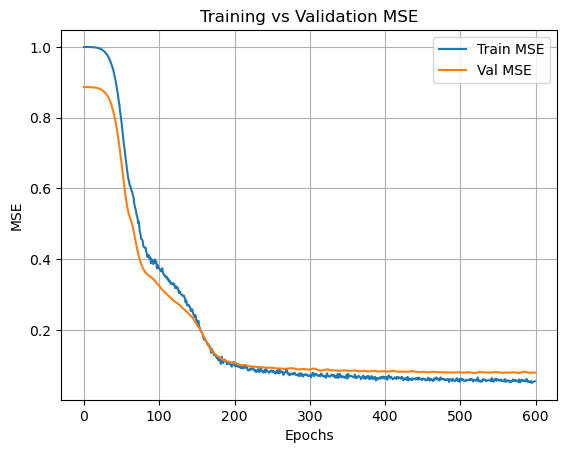

In [129]:
# Plotting
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Val MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training vs Validation MSE")
plt.legend()
plt.grid()
plt.show()

##### Predictions on test data

In [130]:
filepath_test = "../ML_project/data/cup/ML-CUP24-TS.csv"

df = pd.read_csv(filepath_test, skiprows=7, header=None)
df.columns = ["ID"] + [f'input_{i}' for i in range(12)]
df = df.drop('ID', axis=1)

X_test, _ = normalize(data=df.iloc[:, :12], type='z-score')
X_test = X_test.to_numpy(dtype=np.float32)

X_test.shape

(500, 12)

In [131]:
# Prediction
y_pred = model.forward(X_test, training=False)
y_pred

array([[-0.44036247, -1.30930447,  0.7372385 ],
       [-0.26525804,  1.70222053,  0.65250384],
       [ 0.46678825,  0.0124206 , -1.32668848],
       ...,
       [ 0.52539062, -1.05807194,  0.76751553],
       [ 0.21311922,  0.88717928, -1.24951235],
       [ 0.15249415,  0.23143166, -0.93351733]])

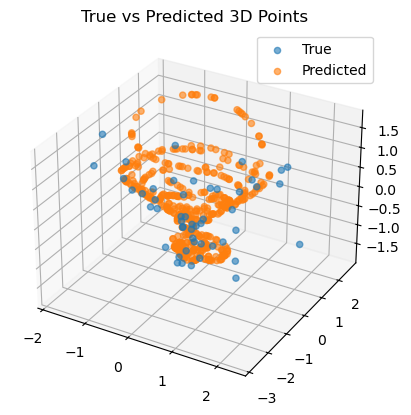

In [134]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_val[:, 0], y_val[:, 1], y_val[:, 2], label='True', alpha=0.6)
ax.scatter(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2],
           label='Predicted', alpha=0.6)
ax.set_title("True vs Predicted 3D Points")
ax.legend()
plt.show()

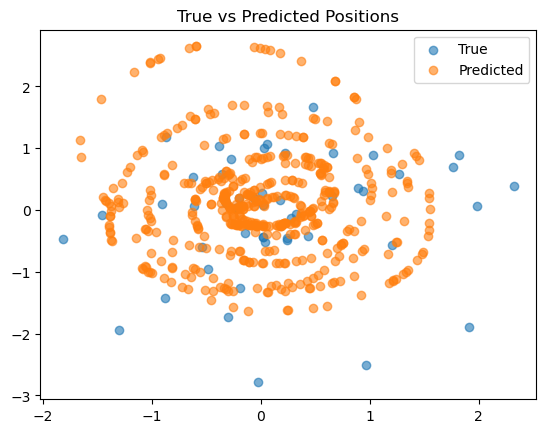

In [133]:
plt.scatter(y_val[:, 0], y_val[:, 1], label="True", alpha=0.6)
plt.scatter(y_pred[:, 0], y_pred[:, 1], label="Predicted", alpha=0.6)
plt.legend()
plt.title("True vs Predicted Positions")
plt.show()

In [119]:
def get_hyperparameters(model, optimizer, epochs, normalize_targets=True, val_ratio=0.2, shuffle=True, seed=42):
    # Extract model architecture
    hidden_sizes = []
    dropout_rates = []
    activations = []

    for i, layer in enumerate(model.layers):
        if isinstance(layer, Layer_Dense):
            hidden_sizes.append(layer.weights.shape[1])
        elif isinstance(layer, Dropout):
            dropout_rates.append(layer.rate)
        elif isinstance(layer, Activation_ReLU):
            activations.append("ReLU")
        elif isinstance(layer, Activation_Linear):
            activations.append("Linear")

    # Assume input size is the shape of the first layer's weight input
    input_size = model.layers[0].weights.shape[0]
    # second last is output dense layer
    output_size = model.layers[-2].weights.shape[1]

    # Fill in dropout for missing layers
    while len(dropout_rates) < len(hidden_sizes):
        dropout_rates.append(0.0)

    return {
        "Data Preprocessing": {
            "Normalization Type": "z-score",
            "Normalize Targets": normalize_targets,
            "Validation Split Ratio": val_ratio,
            "Shuffle": shuffle,
            "Random Seed": seed
        },
        "Model Architecture": {
            "Input Size": input_size,
            "Hidden Sizes": hidden_sizes[:-1],  # exclude output layer
            "Output Size": output_size,
            "Dropout Rates": dropout_rates,
            "Activation Functions": activations
        },
        "Optimizer (Adam)": {
            "Learning Rate": optimizer.learning_rate,
            "Decay": optimizer.decay,
            "Epsilon": optimizer.epsilon,
            "Beta1 (momentum)": 0.9,
            "Beta2 (cache)": 0.999
        },
        "Loss Function": "Mean Squared Error (MSE)",
        "Training": {
            "Epochs": epochs,
            "Loss Logging Frequency": "Every 10 epochs"
        }
    }

In [135]:
from pprint import pprint
hyperparams = get_hyperparameters(model, optimizer, epochs)
pprint(hyperparams)

{'Data Preprocessing': {'Normalization Type': 'z-score',
                        'Normalize Targets': True,
                        'Random Seed': 42,
                        'Shuffle': True,
                        'Validation Split Ratio': 0.2},
 'Loss Function': 'Mean Squared Error (MSE)',
 'Model Architecture': {'Activation Functions': ['ReLU',
                                                 'ReLU',
                                                 'ReLU',
                                                 'Linear'],
                        'Dropout Rates': [0.1, 0.1, 0.0, 0.0],
                        'Hidden Sizes': [64, 32, 16],
                        'Input Size': 12,
                        'Output Size': 3},
 'Optimizer (Adam)': {'Beta1 (momentum)': 0.9,
                      'Beta2 (cache)': 0.999,
                      'Decay': 0.0,
                      'Epsilon': 1e-07,
                      'Learning Rate': 0.001},
 'Training': {'Epochs': 600, 'Loss Logging Frequency': 'E